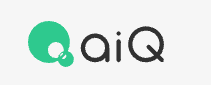

[disclaimer](../../disclaimer.txt/)

# TruValue Data Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html == True:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')
from aiq_strategy_robot.data.data_accessor import DAL
from utils.shortcut import truvalue_dataset as sc

## データロード & AltDataEvaluatorの作成

In [3]:
sdh = DAL()

# Load Fundamental Data
data_id_funda = sc.register_fundamental_data(sdh)
display(sdh.get_raw_data(data_id_funda).tail())

# Price Data (origin: FactSet HTTP API)
data_id_price = sc.register_market_prices(sdh)
display(sdh.get_raw_data(data_id_price).tail())


# ☆TruValue data (origin: FactSet Snowflake)
data_id_tv = sc.register_tv(sdh)
display(sdh.get_raw_data(data_id_tv).tail())

# Set Alias (Optional)
sdh.set_alias({
    data_id_funda: 'funda',
    data_id_price: 'mkt',
    data_id_tv: 'truvalue',
})

sdh.extract_definition


sales
ticker  datetime           
9997-JP 2022-12-31  61675.0
        2023-03-31  51922.0
        2023-06-30  51842.0
        2023-09-30  44263.0
        2023-12-31  60173.0

fsymId  TICKER_REGION    volume   open   high    low  \
ticker  datetime                                                             
9997-JP 2023-10-27  BT5ZHY-R           9997  290300.0  622.0  628.0  622.0   
        2023-10-30  BT5ZHY-R           9997  409300.0  622.0  625.0  607.0   
        2023-10-31  BT5ZHY-R           9997  528300.0  610.0  613.0  604.0   
        2023-11-01  BT5ZHY-R           9997  421200.0  627.0  633.0  619.0   
        2023-11-02  BT5ZHY-R           9997  323800.0  631.0  631.0  621.0   

                    close currency  
ticker  datetime                    
9997-JP 2023-10-27  626.0      JPY  
        2023-10-30  612.0      JPY  
        2023-10-31  612.0      JPY  
        2023-11-01  628.0      JPY  
        2023-11-02  628.0      JPY

MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  \
ticker  datetime                                                    
9997-JP 2023-11-16                    64.42                 40.63   
        2023-11-17                    64.41                 40.35   
        2023-11-18                    64.40                 40.28   
        2023-11-19                    64.35                 40.37   
        2023-11-20                    64.40                 40.23   

                    ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
ticker  datetime                                                         
9997-JP 2023-11-16                       76.55               76.545724   
        2023-11-17                       76.56               76.564881   
        2023-11-18                       76.58               76.583965   
        2023-11-19                       76.60               76.602976   
        2023-11-20                       76.62               76.621916   

                    ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  
ticker  datetime                                                   
9997-JP 2023-11-16                81.457731               81.5853  
        2023-11-17                81.409830               81.5853  
        2023-11-18                81.362007               81.5853  
        2023-11-19                81.314263               81.5853  
        2023-11-20                81.266596               81.5853

category data_source      source    table     alias  \
data_id                                                       
1        RawData    external      sample  Unknown     funda   
2        RawData     FACTSET  gpd_prices  Unknown       mkt   
3        RawData     FACTSET   TrueValue  Unknown  truvalue   

                                                   tickers  \
data_id                                                      
1        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
2        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   
3        [1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [ticker, datetime]  2008-03-31 00:00:00  2024-01-31 00:00:00  
2        [ticker, datetime]  2016-01-04 00:00:00  2023-11-02 00:00:00  
3        [ticker, datetime]  2016-01-01 00:00:00  2023-11-20 00:00:00

### AltDataEvaluatorを作成

In [4]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

## 相関計算

### 四半期売上高との相関を計算

> 売上高の時系列幅に合わせてリサンプルします.

In [5]:
sdh.transform.clear()
funda_sales_id = sdh.transform.resample(data_id=data_id_funda, rule='Q', func='last').variable_ids[0]
tv_Q_ids = sdh.transform.resample(data_id=data_id_tv, rule='Q', func='last').variable_ids

#### 四半期売上高とのプロット

ハンドラの`show_line_one_target`で、特定TickerのKPI(y)とTruValuデータとのプロットを行います.

Variables being created: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


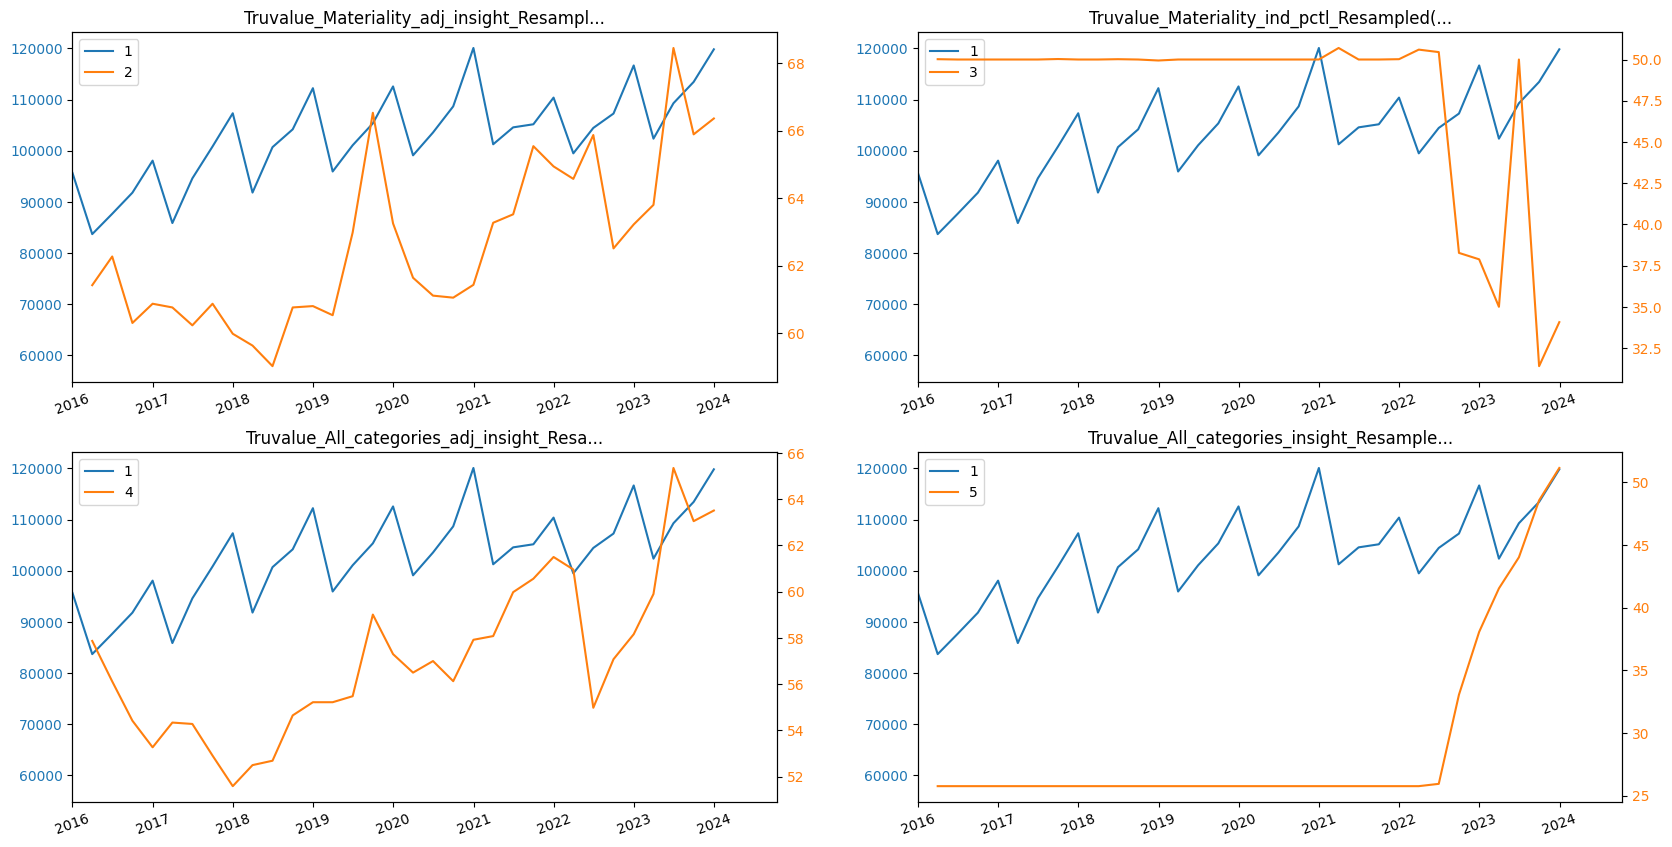

In [6]:
sample_target = "2281-JP"

sdh.show_line_one_target(
    target=sample_target,
    y=funda_sales_id,
    X= tv_Q_ids[:4],
    col_num=2,
    vname_len_limit=40,
    start_date='2016-01-01'
)

> データの時系列をshiftすることで売上高とのプロットがどのように変化するかを見ます.

In [7]:
tv_shft10_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=10).resample(rule='Q', func='mean').variable_ids
tv_shft11_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=11).resample(rule='Q', func='mean').variable_ids
tv_shft12_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=12).resample(rule='Q', func='mean').variable_ids
tv_shft13_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=13).resample(rule='Q', func='mean').variable_ids
tv_shft14_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=14).resample(rule='Q', func='mean').variable_ids
tv_shft15_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=15).resample(rule='Q', func='mean').variable_ids
tv_shft16_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=16).resample(rule='Q', func='mean').variable_ids
tv_shft17_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=17).resample(rule='Q', func='mean').variable_ids
tv_shft18_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=18).resample(rule='Q', func='mean').variable_ids
tv_shft19_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=19).resample(rule='Q', func='mean').variable_ids
tv_shft20_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=20).resample(rule='Q', func='mean').variable_ids
tv_shft21_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=21).resample(rule='Q', func='mean').variable_ids
tv_shft22_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=22).resample(rule='Q', func='mean').variable_ids
tv_shft23_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=23).resample(rule='Q', func='mean').variable_ids
tv_shft24_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=24).resample(rule='Q', func='mean').variable_ids
tv_shft25_Q_ids = sdh.transform.shift(data_id=data_id_tv, periods=25).resample(rule='Q', func='mean').variable_ids

Variables being created: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


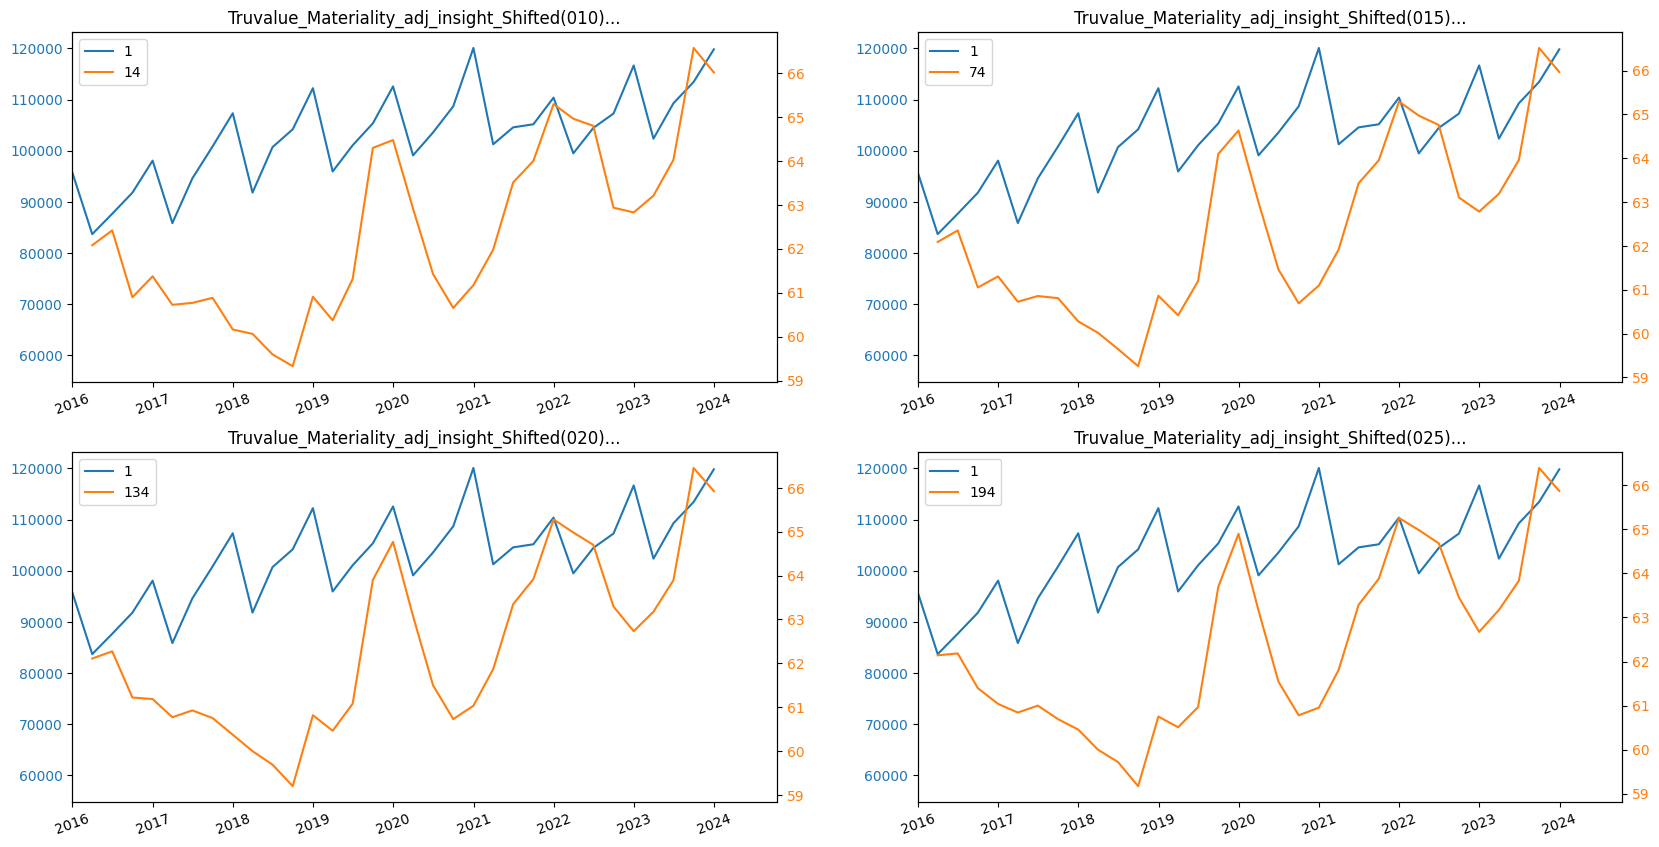

In [8]:
sample_target = "2281-JP"

sdh.show_line_one_target(
    target=sample_target,
    y=funda_sales_id,
    X= [tv_shft10_Q_ids[0], tv_shft15_Q_ids[0], tv_shft20_Q_ids[0], tv_shft25_Q_ids[0]],
    col_num=2,
    vname_len_limit=45,
    start_date='2016-01-01'
)

> 特徴量を対数変換して相関計算を行います


In [9]:
sales_id = sdh.transform.log_diff(fields=funda_sales_id, periods=4).diff(periods=1).variable_ids[-1]
tv_shft11_Q_log_ids = sdh.transform.log_diff(fields=tv_shft11_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft12_Q_log_ids = sdh.transform.log_diff(fields=tv_shft12_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft13_Q_log_ids = sdh.transform.log_diff(fields=tv_shft13_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft14_Q_log_ids = sdh.transform.log_diff(fields=tv_shft14_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft15_Q_log_ids = sdh.transform.log_diff(fields=tv_shft15_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft16_Q_log_ids = sdh.transform.log_diff(fields=tv_shft16_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft17_Q_log_ids = sdh.transform.log_diff(fields=tv_shft17_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft18_Q_log_ids = sdh.transform.log_diff(fields=tv_shft18_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft19_Q_log_ids = sdh.transform.log_diff(fields=tv_shft19_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft20_Q_log_ids = sdh.transform.log_diff(fields=tv_shft20_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft21_Q_log_ids = sdh.transform.log_diff(fields=tv_shft21_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft22_Q_log_ids = sdh.transform.log_diff(fields=tv_shft22_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft23_Q_log_ids = sdh.transform.log_diff(fields=tv_shft23_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft24_Q_log_ids = sdh.transform.log_diff(fields=tv_shft24_Q_ids, periods=4).diff(periods=1).variable_ids
tv_shft25_Q_log_ids = sdh.transform.log_diff(fields=tv_shft25_Q_ids, periods=4).diff(periods=1).variable_ids

#### 相関計算

In [10]:
ori_cols = sdh.get_raw_data(data_id_tv).columns
ori_cols

Index(['MATERIALITY_ADJ_INSIGHT', 'MATERIALITY_IND_PCTL',
       'ALL_CATEGORIES_ADJ_INSIGHT', 'ALL_CATEGORIES_INSIGHT',
       'ALL_CATEGORIES_MOMENTUM', 'ALL_CATEGORIES_PULSE'],
      dtype='object')

In [11]:
ori_cols = sdh.get_raw_data(data_id_tv).columns
rho_pool = pd.DataFrame()
rho_pool['shift=11'] = ade.compu_rho(tv_shft11_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=12'] = ade.compu_rho(tv_shft12_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=13'] = ade.compu_rho(tv_shft13_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=14'] = ade.compu_rho(tv_shft14_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=15'] = ade.compu_rho(tv_shft15_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=16'] = ade.compu_rho(tv_shft16_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=17'] = ade.compu_rho(tv_shft17_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=18'] = ade.compu_rho(tv_shft18_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=19'] = ade.compu_rho(tv_shft19_Q_log_ids, sales_id, rename_features=ori_cols)
rho_pool['shift=20'] = ade.compu_rho(tv_shft20_Q_log_ids, sales_id, rename_features=ori_cols)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

Variables being created: 100%|██████████| 2/2 [00:00<00:00, 23.62it/s]


shift=11  shift=12  shift=13  shift=14  shift=15  \
MATERIALITY_IND_PCTL        2.613593  2.601191  2.590449  2.631443  2.683585   
MATERIALITY_ADJ_INSIGHT     2.573807  2.592876  2.610979  2.621875  2.630703   
ALL_CATEGORIES_ADJ_INSIGHT  0.680890  0.657117  0.643359  0.616773  0.599475   
ALL_CATEGORIES_MOMENTUM     0.408923  0.422547  0.455099  0.405918  0.402466   
ALL_CATEGORIES_PULSE       -0.427873 -0.462404 -0.466356 -0.444524 -0.513212   
ALL_CATEGORIES_INSIGHT     -1.148880 -1.143702 -1.135696 -1.154380 -1.134228   

                            shift=16  shift=17  shift=18  shift=19  shift=20  
MATERIALITY_IND_PCTL        2.713848  2.696585  2.636527  2.610644  2.568292  
MATERIALITY_ADJ_INSIGHT     2.642365  2.660351  2.668905  2.667751  2.678657  
ALL_CATEGORIES_ADJ_INSIGHT  0.588402  0.583337  0.572315  0.581645  0.583897  
ALL_CATEGORIES_MOMENTUM     0.416451  0.399178  0.391941  0.368110  0.369379  
ALL_CATEGORIES_PULSE       -0.533399 -0.644602 -0.634133 -0.706027 -0.769665  
ALL_CATEGORIES_INSIGHT     -1.137395 -1.113527 -1.116780 -1.110991 -1.097222

> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [12]:
rho_time = ade.compu_rho(tv_shft16_Q_log_ids, sales_id, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('MATERIALITY_IND_PCTL', ascending=False).head()

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
ticker                                                        
2224-JP                    0.057166                     NaN   
7984-JP                    1.463027                1.156091   
2816-JP                    0.057166                     NaN   
2286-JP                    0.800095                     NaN   
2612-JP                    2.041241                     NaN   

         ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  \
ticker                                                   
2224-JP                      NaN                   NaN   
7984-JP                 1.435466             -1.482293   
2816-JP                      NaN                   NaN   
2286-JP                      NaN                   NaN   
2612-JP                      NaN                   NaN   

         MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  
ticker                                                  
2224-JP                -0.532181              5.659453  
7984-JP                 4.129024              3.884952  
2816-JP                -0.172062              3.815836  
2286-JP                 0.532181              2.959800  
2612-JP                 2.424672              2.959800

> 変数を確認して散布図でplot

In [13]:
display(sdh.transform.find_variables(tv_shft16_Q_log_ids))

feature = 269 # MATERIALITY_IND_PCTL

variable_id  data_id  \
variable_name                                                              
Truvalue_Materiality_adj_insight_Shifted(016)_R...          268        3   
Truvalue_Materiality_ind_pctl_Shifted(016)_Resa...          269        3   
Truvalue_All_categories_adj_insight_Shifted(016...          270        3   
Truvalue_All_categories_insight_Shifted(016)_Re...          271        3   
Truvalue_All_categories_momentum_Shifted(016)_R...          272        3   
Truvalue_All_categories_pulse_Shifted(016)_Resa...          273        3   

                                                   data_source     source  \
variable_name                                                               
Truvalue_Materiality_adj_insight_Shifted(016)_R...     FACTSET  TrueValue   
Truvalue_Materiality_ind_pctl_Shifted(016)_Resa...     FACTSET  TrueValue   
Truvalue_All_categories_adj_insight_Shifted(016...     FACTSET  TrueValue   
Truvalue_All_categories_insight_Shifted(016)_Re...     FACTSET  TrueValue   
Truvalue_All_categories_momentum_Shifted(016)_R...     FACTSET  TrueValue   
Truvalue_All_categories_pulse_Shifted(016)_Resa...     FACTSET  TrueValue   

                                                      table  \
variable_name                                                 
Truvalue_Materiality_adj_insight_Shifted(016)_R...  Unknown   
Truvalue_Materiality_ind_pctl_Shifted(016)_Resa...  Unknown   
Truvalue_All_categories_adj_insight_Shifted(016...  Unknown   
Truvalue_All_categories_insight_Shifted(016)_Re...  Unknown   
Truvalue_All_categories_momentum_Shifted(016)_R...  Unknown   
Truvalue_All_categories_pulse_Shifted(016)_Resa...  Unknown   

                                                                                                field  \
variable_name                                                                                           
Truvalue_Materiality_adj_insight_Shifted(016)_R...  Truvalue_Materiality_adj_insight_Shifted(016)_...   
Truvalue_Materiality_ind_pctl_Shifted(016)_Resa...  Truvalue_Materiality_ind_pctl_Shifted(016)_Res...   
Truvalue_All_categories_adj_insight_Shifted(016...  Truvalue_All_categories_adj_insight_Shifted(01...   
Truvalue_All_categories_insight_Shifted(016)_Re...  Truvalue_All_categories_insight_Shifted(016)_R...   
Truvalue_All_categories_momentum_Shifted(016)_R...  Truvalue_All_categories_momentum_Shifted(016)_...   
Truvalue_All_categories_pulse_Shifted(016)_Resa...  Truvalue_All_categories_pulse_Shifted(016)_Res...   

                                                   ticker  reference_id  \
variable_name                                                             
Truvalue_Materiality_adj_insight_Shifted(016)_R...   None           262   
Truvalue_Materiality_ind_pctl_Shifted(016)_Resa...   None           263   
Truvalue_All_categories_adj_insight_Shifted(016...   None           264   
Truvalue_All_categories_insight_Shifted(016)_Re...   None           265   
Truvalue_All_categories_momentum_Shifted(016)_R...   None           266   
Truvalue_All_categories_pulse_Shifted(016)_Resa...   None           267   

                                                   variable_type method  \
variable_name                                                             
Truvalue_Materiality_adj_insight_Shifted(016)_R...       feature   diff   
Truvalue_Materiality_ind_pctl_Shifted(016)_Resa...       feature   diff   
Truvalue_All_categories_adj_insight_Shifted(016...       feature   diff   
Truvalue_All_categories_insight_Shifted(016)_Re...       feature   diff   
Truvalue_All_categories_momentum_Shifted(016)_R...       feature   diff   
Truvalue_All_categories_pulse_Shifted(016)_Resa...       feature   diff   

                                                       params  process_id  
variable_name                                                              
Truvalue_Materiality_adj_insight_Shifted(016)_R...  periods=1          48  
Truvalue_Materiality_ind_pctl_Shifted(016)_Resa...

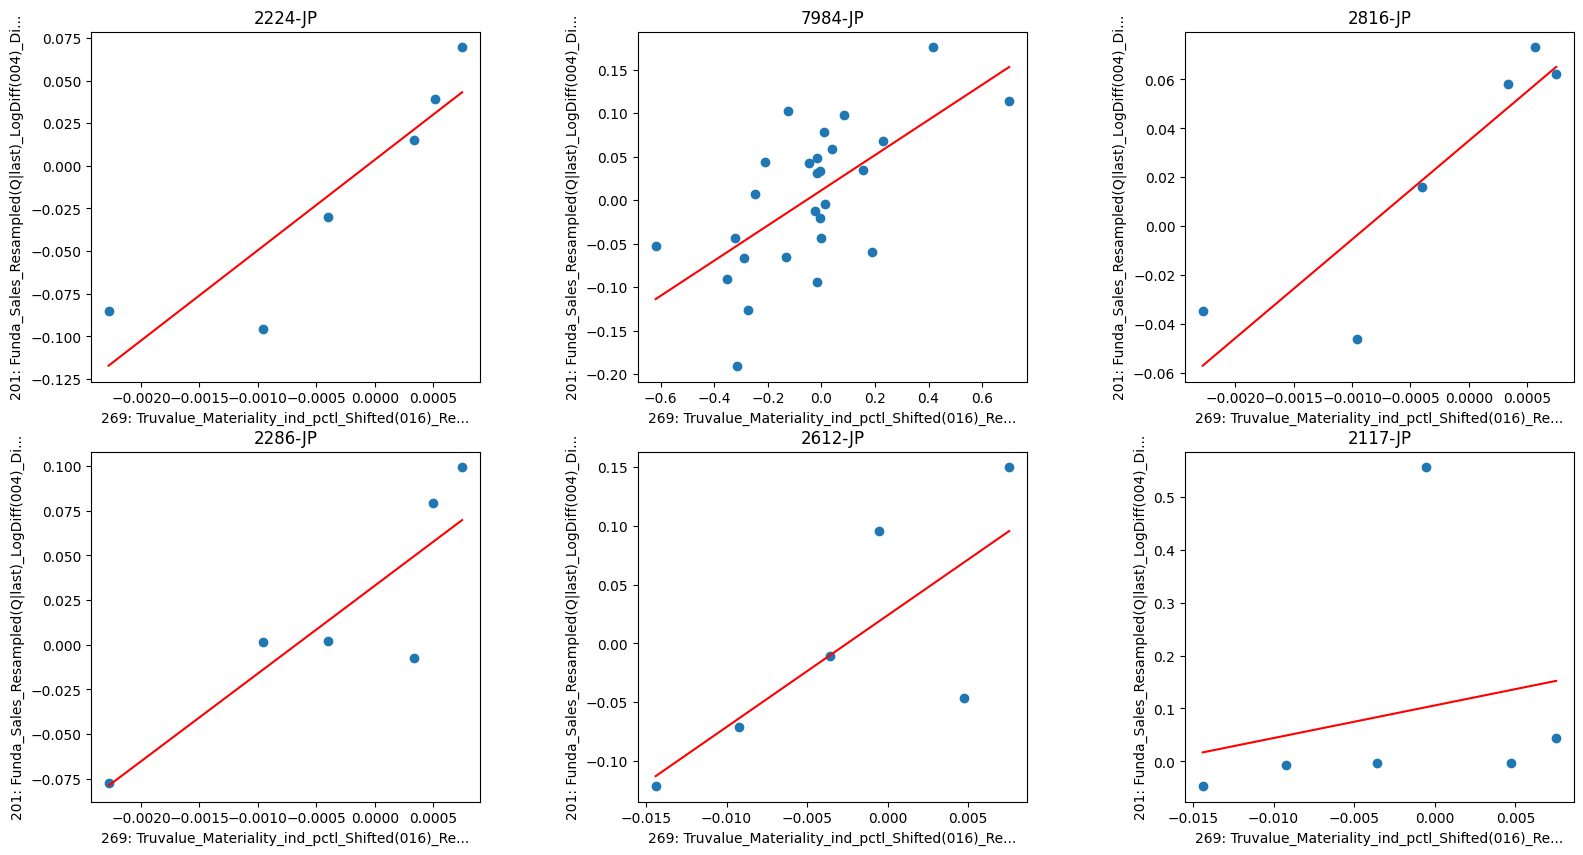

In [14]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('MATERIALITY_IND_PCTL', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_id,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45,
    start_date='2016-01-01'
)

### 株価変化率との相関

> ここでは週次データに変換して分析します.

In [15]:
resample_term = 'W-FRI'

mkt_W_open_id = sdh.transform.resample(data_id=data_id_price, fields='open', rule=resample_term, func='first', label='left', closed='left').variable_ids[-1]
tv_W_ids = sdh.transform.resample(data_id=data_id_tv, rule=resample_term, func='last', label='left', closed='left').variable_ids

価格データとTrueValueをプロット

Variables being created: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


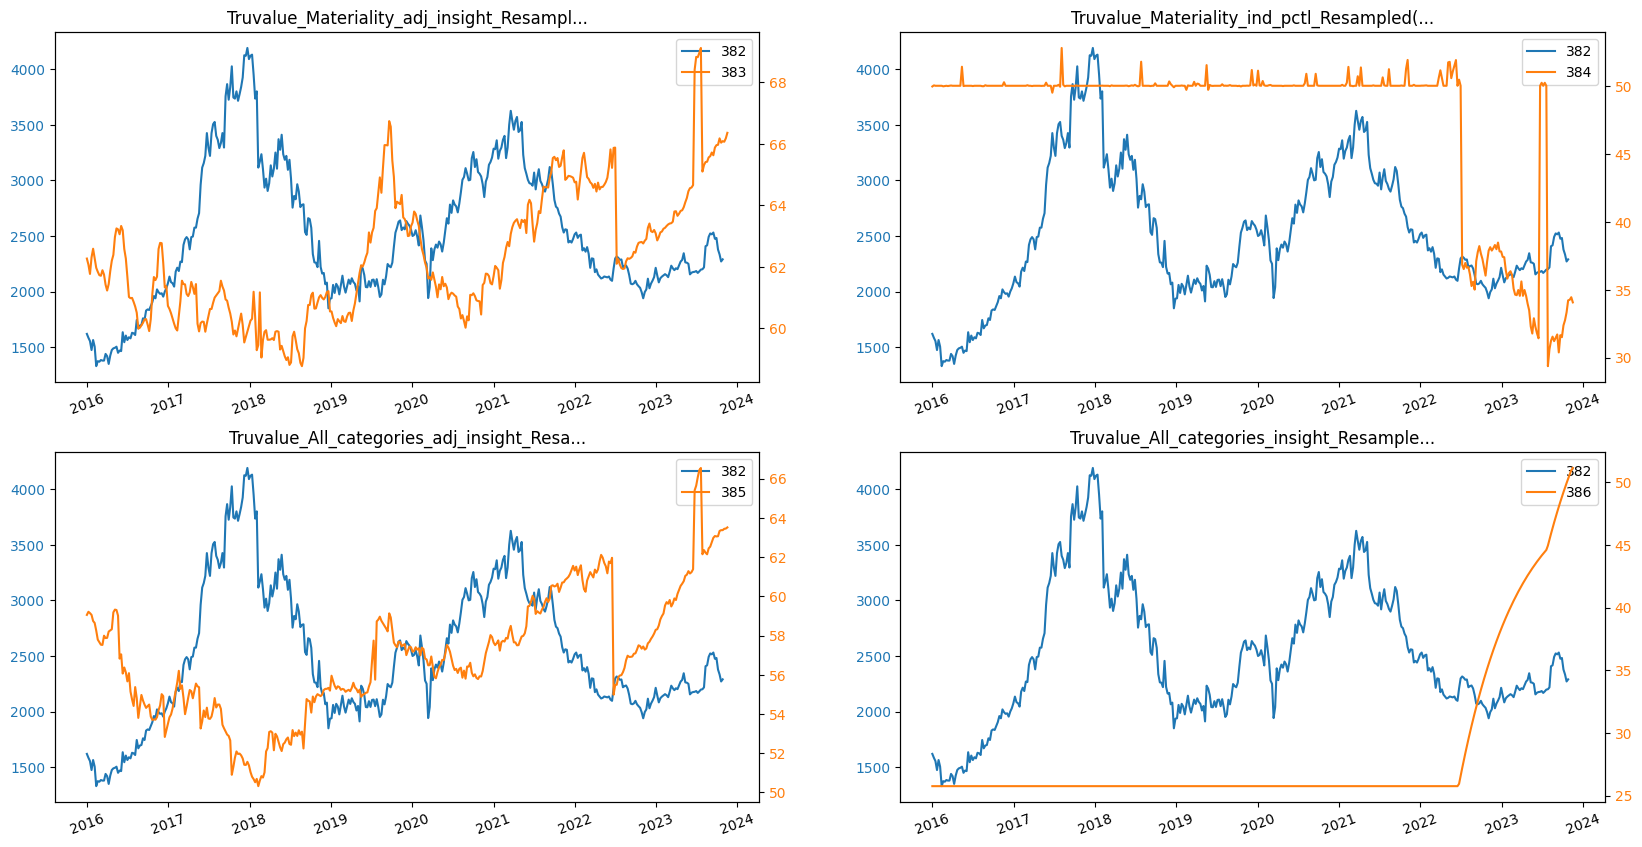

In [16]:
sample_target = "2281-JP"

sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_open_id,
    X= tv_W_ids[:4],
    col_num=2,
    vname_len_limit=40,
)

> データの時系列をshiftすることで売上高とのプロットがどのように変化するかを見ます.

In [17]:
tv_shift1_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=1).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift2_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=2).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift3_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=3).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift4_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=4).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift5_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=5).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift6_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=6).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift7_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=7).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids
tv_shift8_W_ids = sdh.transform.shift(data_id=data_id_tv, periods=8).resample(rule=resample_term, func='last', label='left', closed='left').variable_ids

Variables being created: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


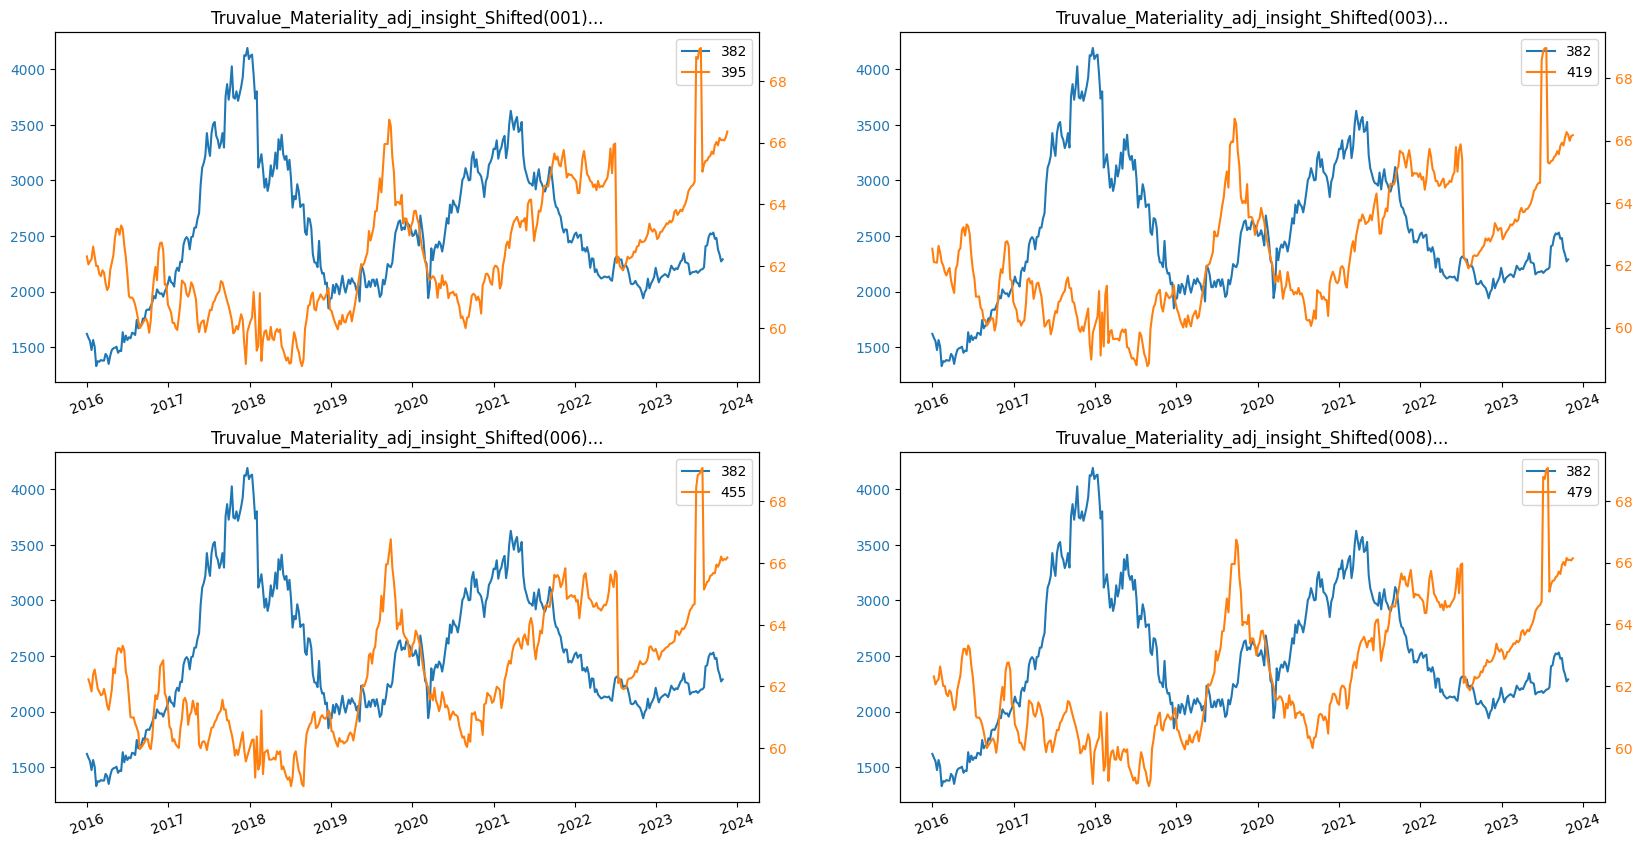

In [18]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_open_id,
    X= [tv_shift1_W_ids[0], tv_shift3_W_ids[0], tv_shift6_W_ids[0], tv_shift8_W_ids[0]],
    col_num=2,
    vname_len_limit=45,
)

> 特徴量を対数変換して相関計算を行う<br>
> TruValueはそのままで使用(shiftのみ）

In [19]:
open_return = sdh.transform.dropna(fields=mkt_W_open_id).log_diff(periods=1).multiply_by_scalar(value=100).variable_ids[-1]

In [20]:
rho_pool = pd.DataFrame()
rho_pool['shift=0'] = ade.compu_rho(tv_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=1'] = ade.compu_rho(tv_shift1_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=2'] = ade.compu_rho(tv_shift2_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=3'] = ade.compu_rho(tv_shift3_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=4'] = ade.compu_rho(tv_shift4_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=5'] = ade.compu_rho(tv_shift5_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=6'] = ade.compu_rho(tv_shift6_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=7'] = ade.compu_rho(tv_shift7_W_ids, open_return, rename_features=ori_cols)
rho_pool['shift=8'] = ade.compu_rho(tv_shift8_W_ids, open_return, rename_features=ori_cols)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

Variables being created: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


shift=0   shift=1   shift=2   shift=3   shift=4  \
ALL_CATEGORIES_PULSE        3.344142  3.295872  3.211110  2.992977  2.860049   
ALL_CATEGORIES_INSIGHT      2.977132  2.977348  2.965339  2.948795  2.951955   
ALL_CATEGORIES_MOMENTUM     2.477013  2.499793  2.486475  2.486441  2.465334   
MATERIALITY_ADJ_INSIGHT     1.705483  1.681338  1.665240  1.616562  1.616806   
MATERIALITY_IND_PCTL        1.439120  1.010977  1.515562  1.954146  0.737007   
ALL_CATEGORIES_ADJ_INSIGHT  0.726608  0.710120  0.679052  0.682749  0.735497   

                             shift=5   shift=6   shift=7   shift=8  
ALL_CATEGORIES_PULSE        2.819685  2.786870  2.687735  2.867985  
ALL_CATEGORIES_INSIGHT      2.949815  2.938599  2.928567  2.924087  
ALL_CATEGORIES_MOMENTUM     2.449180  2.473418  2.438787  2.414705  
MATERIALITY_ADJ_INSIGHT     1.619297  1.684127  1.605512  1.570725  
MATERIALITY_IND_PCTL        2.011770  1.942459  0.936308  0.628365  
ALL_CATEGORIES_ADJ_INSIGHT  0.719452  0.742505  0.679632  0.668263

> もっとも相関の良い変数のうち、さらに上記N件のTickerを確認します.

In [21]:
rho_time = ade.compu_rho(tv_W_ids, open_return, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).head()

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



ALL_CATEGORIES_ADJ_INSIGHT  ALL_CATEGORIES_INSIGHT  \
ticker                                                        
2109-JP                    2.254271                3.745420   
2805-JP                    1.588009                3.242712   
2914-JP                    2.627628                2.627770   
4188-JP                    2.365212                2.363773   
2267-JP                    0.832847                0.832744   

         ALL_CATEGORIES_MOMENTUM  ALL_CATEGORIES_PULSE  \
ticker                                                   
2109-JP                 2.405635              3.473136   
2805-JP                 3.003294              3.092613   
2914-JP                 0.936111              2.446329   
4188-JP                 2.895031              2.292204   
2267-JP                 1.718979              2.103774   

         MATERIALITY_ADJ_INSIGHT  MATERIALITY_IND_PCTL  
ticker                                                  
2109-JP                 0.850065              2.340498  
2805-JP                 1.622317              2.408400  
2914-JP                 2.050671             -0.880109  
4188-JP                 1.891842              2.332360  
2267-JP                 0.774713              0.538611

> 変数を確認して散布図でplot

In [22]:
display(sdh.transform.find_variables(tv_W_ids))

feature = 388 # ALL_CATEGORIES_PULSE

variable_id  data_id  \
variable_name                                                              
Truvalue_Materiality_adj_insight_Resampled(W-FR...          383        3   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...          384        3   
Truvalue_All_categories_adj_insight_Resampled(W...          385        3   
Truvalue_All_categories_insight_Resampled(W-FRI...          386        3   
Truvalue_All_categories_momentum_Resampled(W-FR...          387        3   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...          388        3   

                                                   data_source     source  \
variable_name                                                               
Truvalue_Materiality_adj_insight_Resampled(W-FR...     FACTSET  TrueValue   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...     FACTSET  TrueValue   
Truvalue_All_categories_adj_insight_Resampled(W...     FACTSET  TrueValue   
Truvalue_All_categories_insight_Resampled(W-FRI...     FACTSET  TrueValue   
Truvalue_All_categories_momentum_Resampled(W-FR...     FACTSET  TrueValue   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...     FACTSET  TrueValue   

                                                      table  \
variable_name                                                 
Truvalue_Materiality_adj_insight_Resampled(W-FR...  Unknown   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...  Unknown   
Truvalue_All_categories_adj_insight_Resampled(W...  Unknown   
Truvalue_All_categories_insight_Resampled(W-FRI...  Unknown   
Truvalue_All_categories_momentum_Resampled(W-FR...  Unknown   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...  Unknown   

                                                                         field  \
variable_name                                                                    
Truvalue_Materiality_adj_insight_Resampled(W-FR...     MATERIALITY_ADJ_INSIGHT   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...        MATERIALITY_IND_PCTL   
Truvalue_All_categories_adj_insight_Resampled(W...  ALL_CATEGORIES_ADJ_INSIGHT   
Truvalue_All_categories_insight_Resampled(W-FRI...      ALL_CATEGORIES_INSIGHT   
Truvalue_All_categories_momentum_Resampled(W-FR...     ALL_CATEGORIES_MOMENTUM   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...        ALL_CATEGORIES_PULSE   

                                                   ticker reference_id  \
variable_name                                                            
Truvalue_Materiality_adj_insight_Resampled(W-FR...   None         None   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...   None         None   
Truvalue_All_categories_adj_insight_Resampled(W...   None         None   
Truvalue_All_categories_insight_Resampled(W-FRI...   None         None   
Truvalue_All_categories_momentum_Resampled(W-FR...   None         None   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...   None         None   

                                                   variable_type    method  \
variable_name                                                                
Truvalue_Materiality_adj_insight_Resampled(W-FR...       feature  resample   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...       feature  resample   
Truvalue_All_categories_adj_insight_Resampled(W...       feature  resample   
Truvalue_All_categories_insight_Resampled(W-FRI...       feature  resample   
Truvalue_All_categories_momentum_Resampled(W-FR...       feature  resample   
Truvalue_All_categories_pulse_Resampled(W-FRI|l...       feature  resample   

                                                                                               params  \
variable_name                                                                                           
Truvalue_Materiality_adj_insight_Resampled(W-FR...  rule="W-FRI", func="last", closed="left", labe...   
Truvalue_Materiality_ind_pctl_Resampled(W-FRI|l...  rule="W-FRI", func="last", closed="left", labe...   
Truvalue_All_categories_ad

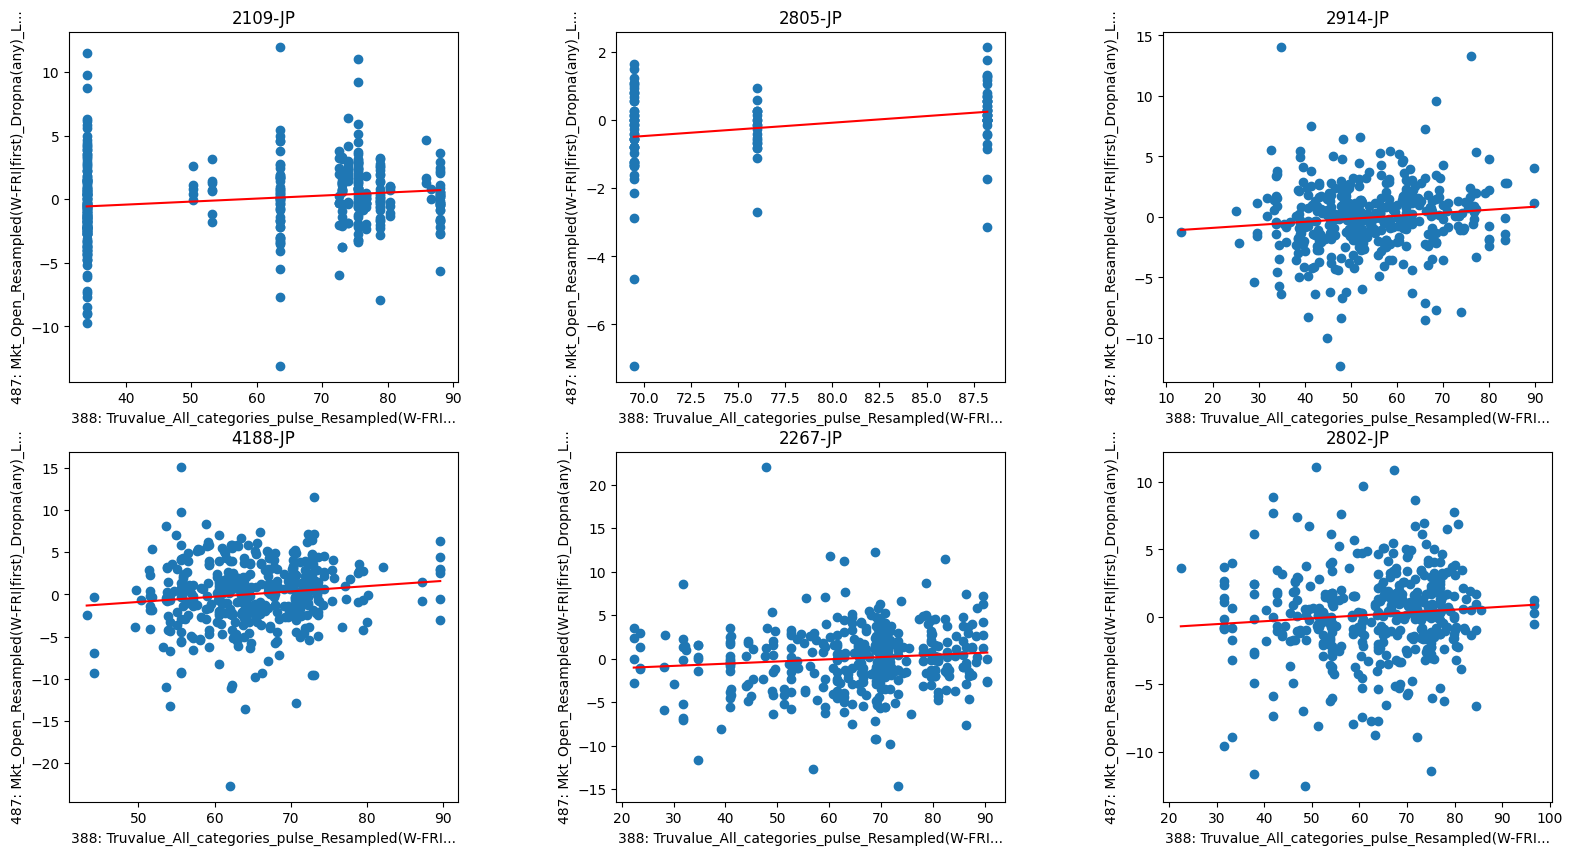

In [23]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('ALL_CATEGORIES_PULSE', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=open_return,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

## バックテスト
> 株価変化率ともっとも相関の良い特徴量をシグナルにして、ポートフォリオ分析を実施します.

In [24]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [25]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature,
    open_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

/home/schiba/work/asr_protected/asr_protected/data_manager/transform/generator.py:271: UserWarning:

Differences exist in the y and X feature universe::{'2204-JP'}.Only use universe that exist in both.



cum.Ret   ann.Ret    ann.Std       R/R     Win_R  ann.TurnOver  \
#1           -5.665984 -0.718834  16.596356 -0.043313  0.529412      3.259662   
#2           23.409880  2.969971  17.184461  0.172829  0.561275      5.969069   
#3           36.792407  4.667789  16.815884  0.277582  0.583333      4.200489   
#3-#1        42.458391  5.386622   5.368059  1.003458  0.553922      7.460151   
#3-#1(cost)  42.429275  5.382929   5.368061  1.002770  0.553922      7.460151   

                Max_DD  Calmar Ratio  
#1          -50.778609     -0.014156  
#2          -45.566623      0.065179  
#3          -40.198806      0.116118  
#3-#1       -10.864002      0.495823  
#3-#1(cost) -10.865440      0.495417